In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# for Aleks
%cd 'gdrive'/'MyDrive'/'4th Year'/'MSCI 598'/'NLP Class Project'

/content/gdrive/MyDrive/4th Year/MSCI 598/NLP Class Project


In [ ]:
# for Parth
%cd 'gdrive'/'MyDrive'/'NLP Class Project'

/content/gdrive/.shortcut-targets-by-id/10KQqN8jXBEsHE_F-Fg6jYXb2a3Vhxm61/NLP Class Project


In [3]:
import os
import re
import csv
from tqdm import tqdm

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from keras import callbacks
from keras import optimizers
from keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from keras.layers.merge import concatenate,subtract
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from keras import backend as K
import tensorflow.python.keras.engine

tf_sess = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth = True))
tf.compat.v1.keras.backend.set_session(tf_sess)

In [5]:
# Tunable hyperparams
MAX_VOCAB_SIZE = 28000
EMBEDDING_DIM = 50 
# EMBEDDING_DIM = 768
BATCH_SIZE = 128
HEAD_LEN = 15 
BODY_LEN = 300

In [6]:
import random

def get_bodies(path_bodies, is_test=False):
  with open(path_bodies, encoding='utf_8') as fb:  # Body ID,articleBody
    body_dict = {}
    lines_b = csv.reader(fb)
    for i, line in enumerate(tqdm(list(lines_b), ncols=80, leave=False)):
        if i > 0:
            body_id = int(line[0].strip())
            body_dict[body_id] = line[1]
  
  original =  list(body_dict.keys())
  random.shuffle(original)
  shuffled = [(key, body_dict[key]) for key in original]
  random.shuffle(shuffled)

  if not is_test:
    train, validate = np.split(shuffled, [int(len(shuffled)*0.8)])
    train_dict, val_dict = {}, {}
    for i in train:
      train_dict[i[0]] = i[1]
    for i in validate:
      val_dict[i[0]] = i[1]
    return train_dict, val_dict
  else:
    test, _ = np.split(shuffled, [int(len(shuffled))])
    test_dict = {}
    for i in test:
      test_dict[i[0]] = i[1]
    return test_dict, _


def fnc(path_headlines, body_dict):
  map = {'agree': 0, 'disagree':1, 'discuss':2, 'unrelated':3}
  with open(path_headlines, encoding='utf_8') as fh: # Headline,Body ID,Stance
      lines_h = csv.reader(fh)
      h = []
      b = []
      l = []
      body_ids = []
      for i, line in enumerate(tqdm(list(lines_h), ncols=80, leave=False)):
          if i > 0:
              body_id = int(line[1].strip())
              label = line[2].strip()
              # print(str(body_id))
              if label in map and str(body_id) in body_dict:
                  h.append(line[0])
                  l.append(map[line[2]])
                  b.append(body_dict[str(body_id)])
                  body_ids.append(body_id)
  return h, b, l, body_ids

# Directory for competetion directory
data_dir = './fnc-1'

train_bodies_dict, val_bodies_dict = get_bodies(os.path.join(data_dir, 'train_bodies.csv'))
headlines, bodies, stances, _ = fnc(os.path.join(data_dir, 'train_stances.csv'), train_bodies_dict)
list_of_tuples = list(zip(headlines, bodies, stances))
train_df = pd.DataFrame(list_of_tuples, columns=['headline', 'body_text', 'stances'])

headlines, bodies, stances, _ = fnc(os.path.join(data_dir, 'train_stances.csv'), val_bodies_dict)
list_of_tuples = list(zip(headlines, bodies, stances))
val_df = pd.DataFrame(list_of_tuples, columns=['headline', 'body_text', 'stances'])

train_stances = pd.Series(train_df['stances']).to_numpy()
val_stances = pd.Series(val_df['stances']).to_numpy()

# Data augmentation
train_df_short = train_df.copy()
for index, row in train_df_short.iterrows():
    row['body_text'] = row['body_text'][:len(row['body_text'])*3//4]

train_df_combined = pd.concat([train_df, train_df_short])

test_bodies_dict, _ = get_bodies(os.path.join(data_dir, 'competition_test_bodies.csv'), is_test=True)
headlines, bodies, stances, test_body_ids = fnc(os.path.join(data_dir, 'competition_test_stances.csv'), test_bodies_dict)
list_of_tuples = list(zip(headlines, bodies, stances, test_body_ids))
test_df = pd.DataFrame(list_of_tuples, columns=['headline', 'body_text', 'stances', 'Body ID'])

# test_df = pd.DataFrame(list(zip(headlines, bodies, stances, test_body_ids)), columns=['headline', 'body_text', 'stances', 'Body ID'])
test_mini_df = test_df.copy()
test_mini_df = test_mini_df.drop(test_mini_df.index[10000:])
test_mini_stances = pd.Series(test_mini_df['stances']).to_numpy()
test_stances = pd.Series(test_df['stances']).to_numpy()

                                                headline  \
0      Ferguson riots: Pregnant woman loses eye after...   
1      Crazy Conservatives Are Sure a Gitmo Detainee ...   
2      A Russian Guy Says His Justin Bieber Ringtone ...   
3      Zombie Cat: Buried Kitty Believed Dead, Meows ...   
4      Argentina's President Adopts Boy to End Werewo...   
...                                                  ...   
25408  The success of the Affordable Care Act is a hu...   
25409  The success of the Affordable Care Act is a hu...   
25410  The success of the Affordable Care Act is a hu...   
25411  The success of the Affordable Care Act is a hu...   
25412  The success of the Affordable Care Act is a hu...   

                                               body_text  stances  Body ID  
0      A RESPECTED senior French police officer inves...        3     2008  
1      Dave Morin's social networking company Path is...        3     1550  
2      A bereaved Afghan mother took revenge on 

In [7]:
# Data preprocessing and preparation
sequences, h_sequences, b_sequences = [], [], []

for each in train_df['headline']:
  h_sequences.append(text_to_word_sequence(each))
for each in train_df['body_text']:
  b_sequences.append(text_to_word_sequence(each))
for i in range(len(h_sequences)):
    sequences.append(h_sequences[i])
for i in range(len(b_sequences)):
    sequences.append(b_sequences[i])

tokens = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+/:;<=>@[\\]^`{|}~\t\n')
tokens.fit_on_texts([seq for seq in sequences])
vocab_size = len(tokens.word_index)+1

h_val_seq, b_val_seq = [], []
for each in val_df['headline']:
  h_val_seq.append(text_to_word_sequence(each))
for each in val_df['body_text']:
  b_val_seq.append(text_to_word_sequence(each))

h_test_seq, b_test_seq = [], []
for each in test_df['headline']:
  h_test_seq.append(text_to_word_sequence(each))
for each in test_df['body_text']:
  b_test_seq.append(text_to_word_sequence(each))

X_h_train = tokens.texts_to_sequences([' '.join(seq[:HEAD_LEN]) for seq in h_sequences])
X_h_train = pad_sequences(X_h_train, maxlen=HEAD_LEN, padding='post', truncating='post')
X_b_train = tokens.texts_to_sequences([' '.join(seq[:BODY_LEN]) for seq in b_sequences])
X_b_train = pad_sequences(X_b_train, maxlen=BODY_LEN, padding='post', truncating='post')

X_h_val = tokens.texts_to_sequences([' '.join(seq[:HEAD_LEN]) for seq in h_val_seq])
X_h_val = pad_sequences(X_h_val, maxlen=HEAD_LEN, padding='post', truncating='post')
X_b_val = tokens.texts_to_sequences([' '.join(seq[:BODY_LEN]) for seq in b_val_seq])
X_b_val = pad_sequences(X_b_val, maxlen=BODY_LEN, padding='post', truncating='post')

X_h_test = tokens.texts_to_sequences([' '.join(seq[:HEAD_LEN]) for seq in h_test_seq])
X_h_test = pad_sequences(X_h_test, maxlen=HEAD_LEN, padding='post', truncating='post')
X_b_test = tokens.texts_to_sequences([' '.join(seq[:BODY_LEN]) for seq in b_test_seq])
X_b_test = pad_sequences(X_b_test, maxlen=BODY_LEN, padding='post', truncating='post')

X_train = [X_h_train,X_b_train]
y_train = np_utils.to_categorical(train_stances)
X_val = [X_h_val,X_b_val]
y_val = np_utils.to_categorical(val_stances)
X_test = [X_h_test,X_b_test]
y_test = np_utils.to_categorical(test_stances)


In [8]:
# GloVe Embeddings
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

glove2word2vec('./glove/glove_twitter/glove.twitter.27B.50d.txt', 'glove.50d.txt.word2vec')
embeddings = gensim.models.KeyedVectors.load_word2vec_format('glove.50d.txt.word2vec', binary=False)

embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokens.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokens.word_index.items(): # i=0 is the embedding for the zero padding
  try:
      embeddings_vector = embeddings[word]
  except KeyError:
      embeddings_vector = None
  if embeddings_vector is not None:
      embeddings_matrix[i] = embeddings_vector

del embeddings

In [ ]:
# BERT Embeddings
# !pip -q install simpletransformers
from simpletransformers.language_representation import RepresentationModel

model = RepresentationModel(
        model_type="bert",
        model_name="bert-base-uncased",
        use_cuda=False
    )
lister = list(tokens.word_index.keys())
bert_embeddings = model.encode_sentences(lister, combine_strategy="mean")
print("BERT Embeddings Received")

embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokens.word_index)+1, 768)) # +1 is because the matrix indices start with 0
for word, i in tokens.word_index.items(): # i=0 is the embedding for the zero padding
  try:
      embeddings_vector = bert_embeddings[i-1]
  except KeyError:
      embeddings_vector = None
  if embeddings_vector is not None:
      embeddings_matrix[i] = embeddings_vector

del bert_embeddings

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTextRepresentation: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT Embeddings Received


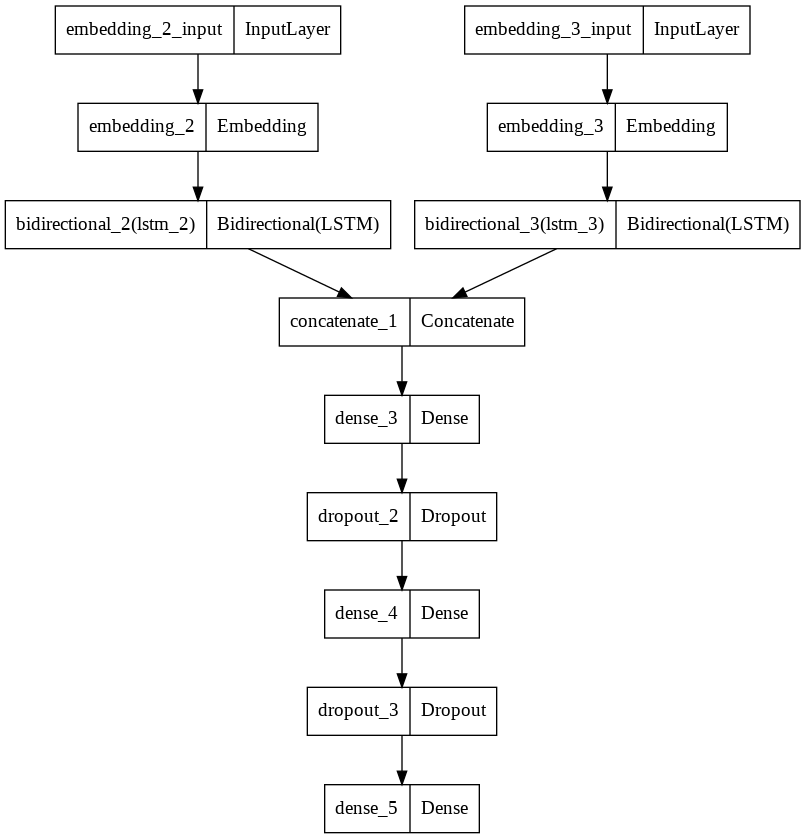

In [10]:
# Build LSTM Model 
from keras.layers import add, Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

headings_model = Sequential()
headings_model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embeddings_matrix], trainable=False))
headings_model.add(Conv1D(filters=32, kernel_size=8, activation='relu', input_shape=(None, None, 50))) # Comment out to remove 1D Conv layer
headings_model.add(MaxPooling1D(pool_size=2))
headings_model.add(Bidirectional(LSTM(80, return_sequences=False)))

body_model = Sequential()
body_model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embeddings_matrix], trainable=False))
body_model.add(Conv1D(filters=32, kernel_size=8, activation='relu', input_shape=(None, None, 50))) # Comment out to remove 1D Conv layer
body_model.add(MaxPooling1D(pool_size=2))
body_model.add(Bidirectional(LSTM(80, return_sequences=False)))

concatenated = concatenate([headings_model.output,body_model.output])
layer_1 = Dense(120, activation='relu') (concatenated)
dropout_1 = Dropout(rate=0.5)(layer_1)
layer_2 =Dense(60,  activation='relu') (dropout_1)
dropout_2 = Dropout(rate=0.5)(layer_2)
out2 = Dense(4, activation='softmax')(dropout_2)
final_model = Model([headings_model.input, body_model.input], out2)

opt = Adam(learning_rate=0.001)
final_model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

plot_model(final_model)

In [ ]:
# Model training 
model_trained = final_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
316/316 [==============================] - 30s 77ms/step - loss: 0.8414 - accuracy: 0.7224 - val_loss: 0.7528 - val_accuracy: 0.7514
Epoch 2/30
316/316 [==============================] - 22s 69ms/step - loss: 0.7319 - accuracy: 0.7392 - val_loss: 0.6671 - val_accuracy: 0.7544
Epoch 3/30
316/316 [==============================] - 21s 68ms/step - loss: 0.5680 - accuracy: 0.7816 - val_loss: 0.6409 - val_accuracy: 0.7361
Epoch 4/30
316/316 [==============================] - 21s 68ms/step - loss: 0.4711 - accuracy: 0.8162 - val_loss: 0.6556 - val_accuracy: 0.7012
Epoch 5/30
316/316 [==============================] - 21s 68ms/step - loss: 0.3972 - accuracy: 0.8451 - val_loss: 0.5960 - val_accuracy: 0.7519
Epoch 6/30
316/316 [==============================] - 21s 67ms/step - loss: 0.3397 - accuracy: 0.8691 - val_loss: 0.5877 - val_accuracy: 0.7681
Epoch 7/30
316/316 [==============================] - 21s 68ms/step - loss: 0.2922 - accuracy: 0.8902 - val_loss: 0.6267 - val_accuracy:

In [ ]:
final_model.save('lstm_base_model/bi_lstm_base.h5')

In [ ]:
# Obtain saved model 
from keras import models

model_file_path = 'lstm_base_model/bi_lstm_base.h5'
answer_path = 'lstm_base_model/answer.csv'
model = models.load_model(model_file_path)

In [ ]:
# evaluate model 
validation = final_model.evaluate(X_val,y_val)
testing = final_model.evaluate(X_test,y_test)
# training = model.evaluate(X_train, y_train)

795/795 [==============================] - 12s 16ms/step - loss: 1.9702 - accuracy: 0.6730


In [ ]:
RELATED = [0, 1, 2]
def score_submission(predicted_labels, target):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]
    for i, (g, t) in enumerate(zip(predicted_labels, target)):
            if g == t:
                score += 0.25
                if g != 3:
                    score += 0.50
            if g in RELATED and t in RELATED:
                score += 0.25

            cm[g][t] += 1
    return score,  cm

In [ ]:
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']

prediction = final_model.predict(X_val)
preds = [np.argmax(p, axis = -1) for p in prediction]
predicted_comp = [LABELS[int(a)] for a in preds]
print(predicted_comp)

map = {'agree': 0, 'disagree':1, 'discuss':2, 'unrelated':3}
preds_test = []
for i in predicted_comp:
  preds_test.append(map[i])

fnc_score, cm_test = score_submission(preds_test, val_stances)
best_fnc_score, _ = score_submission(val_stances, val_stances)
print("Score: ", fnc_score, "out of ", best_fnc_score)
print("\nRelative FNC Score: {:.3f}".format(100/best_fnc_score*fnc_score) + "% \n")

['unrelated', 'discuss', 'agree', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'agree', 'discuss', 'unrelated', 'unrelated', 'agree', 'unrelated', 'discuss', 'discuss', 'unrelated', 'discuss', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'agree', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'disagree', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'agree', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'discuss', 'discuss', 'unrelated', 'u

In [ ]:
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']

prediction = final_model.predict(X_test)
preds = [np.argmax(p, axis = -1) for p in prediction]
predicted_comp = [LABELS[int(a)] for a in preds]
print(len(X_test[0]))
map = {'agree': 0, 'disagree':1, 'discuss':2, 'unrelated':3}
preds_test = []

for i in predicted_comp:
  preds_test.append(map[i])

fnc_score, cm_test = score_submission(preds_test, test_stances)
best_fnc_score, _ = score_submission(test_stances, test_stances)
print("Score: ", fnc_score, "out of ", best_fnc_score)
print("\nRelative FNC Score: {:.3f}".format(100/best_fnc_score*fnc_score) + "% \n")

25413
Score:  6733.25 out of  11651.25

Relative FNC Score: 57.790% 



In [ ]:
# Inference
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']

prediction = final_model.predict(X_test)
preds = [np.argmax(p, axis = -1) for p in prediction]
predicted_comp = [LABELS[int(a)] for a in preds]
print(predicted_comp)

answer = {"Headline" : test_df['headline'], "Body ID" : test_df['Body ID'], 'Stance' : predicted_comp}
answer = pd.DataFrame(answer)
answer.to_csv(answer_path, index=False, encoding='utf-8') # From pandas library

['unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'discuss', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'agree', 'agree', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'agree', 'agree', 'discuss', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'agree', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'discuss', 'unrelated', 'unrelated', 'unrelated', 'agree', 'agree', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'unrelated', 'agree', 'unrelated', 'unrelated', 'unrelated',

NameError: ignored